# Lecture 6 - Quantum Monte-Carlo Trajectories

Author: J. R. Johansson (robert@riken.jp), https://jrjohansson.github.io/

This lecture series was developed by J.R. Johannson. The original lecture notebooks are available [here](https://github.com/jrjohansson/qutip-lectures).

This is a slightly modified version of the lectures, to work with the current release of QuTiP. You can find these lectures as a part of the [qutip-tutorials repository](https://github.com/qutip/qutip-tutorials). This lecture and other tutorial notebooks are indexed at the [QuTiP Tutorial webpage](https://qutip.org/tutorials.html).

In [1]:
import matplotlib.font_manager
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image
from qutip import about, basis, destroy, expect, mcsolve, mesolve, steadystate

%matplotlib inline

## Introduction to the Quantum Monte-Carlo trajectory method

The Quantum Monte-Carlo trajectory method is an equation of motion for a single realization of the state vector $\left|\psi(t)\right>$ for a quantum system that interacts with its environment. The dynamics of the wave function is given by the Schrodinger equation,

<center>
$\displaystyle\frac{d}{dt}\left|\psi(t)\right> = - \frac{i}{\hbar} H_{\rm eff} \left|\psi(t)\right>$
</center>

where the Hamiltonian is an effective Hamiltonian that, in addition to the system Hamiltonian $H(t)$, also contains a non-Hermitian contribution due to the interaction with the environment:

<center>
$\displaystyle H_{\rm eff}(t) = H(t) - \frac{i\hbar}{2}\sum_n c_n^\dagger c_n$
</center>

Since the effective Hamiltonian is non-Hermitian, the norm of the wavefunction is decreasing with time, which to first order in a small time step $\delta t$ is given by $\langle\psi(t+\delta t)|\psi(t+\delta t)\rangle \approx 1 - \delta p\;\;\;$, where 

<center>
$\displaystyle \delta p = \delta t \sum_n \left<\psi(t)|c_n^\dagger c_n|\psi(t)\right>$
</center>

The decreasing norm is used to determine when so-called quantum jumps are to be imposed on the dynamics, where we compare $\delta p$ to a random number in the range [0, 1]. If the norm has decreased below the randomly chosen number, we apply a "quantum jump", so that the new wavefunction at $t+\delta t$ is given by

<center>
$\left|\psi(t+\delta t)\right> = c_n \left|\psi(t)\right>/\left<\psi(t)|c_n^\dagger c_n|\psi(t)\right>^{1/2}$ 
</center>

for a randomly chosen collapse operator $c_n$, weighted so the probability that the collapse being described by the nth collapse operator is given by
    
<center>
$\displaystyle P_n = \left<\psi(t)|c_n^\dagger c_n|\psi(t)\right>/{\delta p}$ 
</center>


## Decay of a single-photon Fock state in a cavity

This is a Monte-Carlo simulation showing the decay of a cavity Fock state $\left|1\right>$ in a thermal environment with an average occupation number of $n=0.063$ .

Here, the coupling strength is given by the inverse of the cavity ring-down time $T_c = 0.129$ .

The parameters chosen here correspond to those from S. Gleyzes, et al., Nature 446, 297 (2007), and we will carry out a simulation that corresponds to these experimental results from that paper:

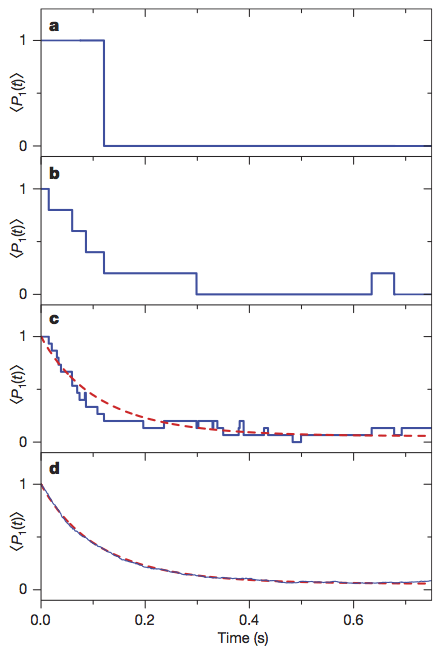

In [2]:
Image(filename="images/exdecay.png")

### Problem parameters

In [3]:
N = 4  # number of basis states to consider
kappa = 1.0 / 0.129  # coupling to heat bath
nth = 0.063  # temperature with <n>=0.063

tlist = np.linspace(0, 0.6, 100)

## Create operators, Hamiltonian and initial state

Here we create QuTiP `Qobj` representations of the operators and state that are involved in this problem.

In [4]:
a = destroy(N)  # cavity destruction operator
H = a.dag() * a  # harmonic oscillator Hamiltonian
psi0 = basis(N, 1)  # initial Fock state with one photon: |1>

## Create a list of collapse operators that describe the dissipation

In [5]:
# collapse operator list
c_op_list = []

# decay operator
c_op_list.append(np.sqrt(kappa * (1 + nth)) * a)

# excitation operator
c_op_list.append(np.sqrt(kappa * nth) * a.dag())

## Monte-Carlo simulation

Here we start the Monte-Carlo simulation, and we request expectation values of photon number operators with 1, 5, 15, and 904 trajectories (compare with experimental results above).

In [6]:
ntraj = [1, 5, 15, 904]  # list of number of trajectories to avg. over

mc = mcsolve(H, psi0, tlist, c_op_list, [a.dag() * a], ntraj)

10.1%. Run time:   0.42s. Est. time left: 00:00:00:03


20.0%. Run time:   0.73s. Est. time left: 00:00:00:02


30.1%. Run time:   1.03s. Est. time left: 00:00:00:02


40.0%. Run time:   1.33s. Est. time left: 00:00:00:01


50.0%. Run time:   1.64s. Est. time left: 00:00:00:01


60.1%. Run time:   1.97s. Est. time left: 00:00:00:01


70.0%. Run time:   2.27s. Est. time left: 00:00:00:00


80.1%. Run time:   2.58s. Est. time left: 00:00:00:00


90.0%. Run time:   2.88s. Est. time left: 00:00:00:00


100.0%. Run time:   3.18s. Est. time left: 00:00:00:00


Total run time:   3.19s


The expectation values of $a^\dagger a$ are now available in array ``mc.expect[idx][0]`` where ``idx`` takes values in ``[0,1,2,3]`` corresponding to the averages of ``1, 5, 15, 904`` Monte Carlo trajectories, as specified above. Below we plot the array ``mc.expect[idx][0]`` vs. ``tlist`` for each index ``idx``.

## Lindblad master-equation simulation and steady state

For comparison with the averages of single quantum trajectories provided by the Monte-Carlo solver we here also calculate the dynamics of the Lindblad master equation, which should agree with the Monte-Carlo simultions for infinite number of trajectories.

In [7]:
# run master equation to get ensemble average expectation values
me = mesolve(H, psi0, tlist, c_op_list, [a.dag() * a])

# calulate final state using steadystate solver
final_state = steadystate(H, c_op_list)  # find steady-state
# find expectation value for particle number
fexpt = expect(a.dag() * a, final_state)

## Plot the results

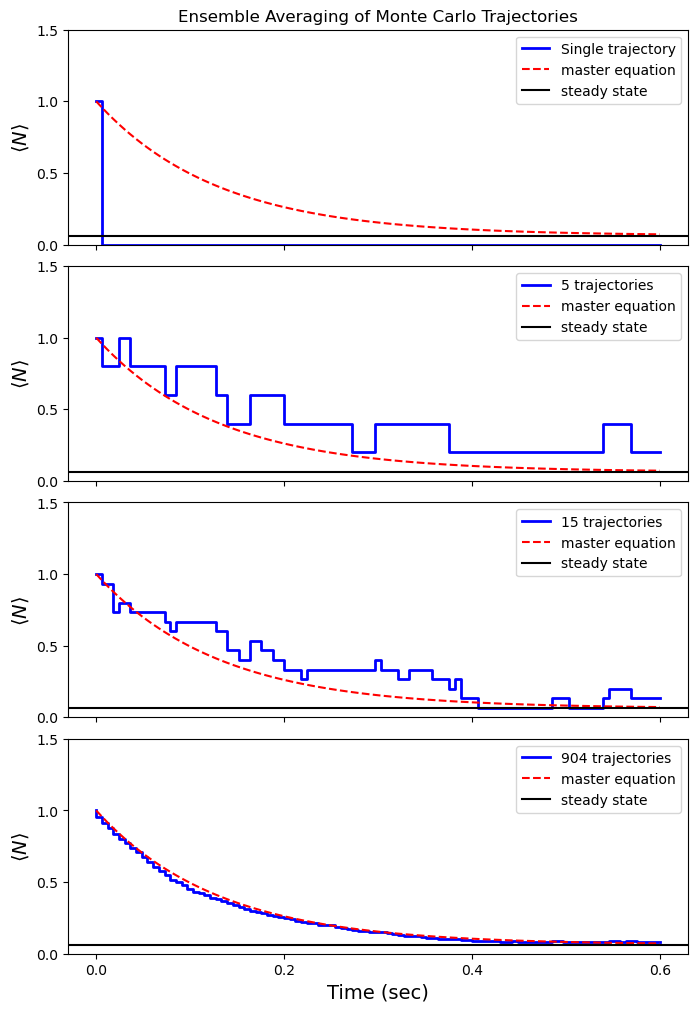

In [8]:
leg_prop = matplotlib.font_manager.FontProperties(size=10)

fig, axes = plt.subplots(4, 1, sharex=True, figsize=(8, 12))

fig.subplots_adjust(hspace=0.1)  # reduce space between plots

for idx, n in enumerate(ntraj):

    axes[idx].step(tlist, mc.expect[idx][0], "b", lw=2)
    axes[idx].plot(tlist, me.expect[0], "r--", lw=1.5)
    axes[idx].axhline(y=fexpt, color="k", lw=1.5)

    axes[idx].set_yticks(np.linspace(0, 2, 5))
    axes[idx].set_ylim([0, 1.5])
    axes[idx].set_ylabel(r"$\left<N\right>$", fontsize=14)

    if idx == 0:
        axes[idx].set_title("Ensemble Averaging of Monte Carlo Trajectories")
        axes[idx].legend(
            ("Single trajectory", "master equation", "steady state"),
            prop=leg_prop
        )
    else:
        axes[idx].legend(
            ("%d trajectories" % n, "master equation", "steady state"),
            prop=leg_prop
        )


axes[3].xaxis.set_major_locator(plt.MaxNLocator(4))
axes[3].set_xlabel("Time (sec)", fontsize=14);

### Software versions:

In [9]:
about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Jake Lishman, Simon Cross and Asier Galicia.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      4.7.1.dev0+c8dd6de
Numpy Version:      1.22.4
Scipy Version:      1.8.1
Cython Version:     0.29.32
Matplotlib Version: 3.5.2
Python Version:     3.10.4
Number of CPUs:     2
BLAS Info:          Generic
OPENMP Installed:   False
INTEL MKL Ext:      False
Platform Info:      Linux (x86_64)
Installation path:  /home/runner/work/qutip-tutorials/qutip-tutorials/qutip/qutip
Please cite QuTiP in your publication.
For your convenience a bibtex reference can b